# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip install Pillow==4.1.1

!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

tcmalloc: large alloc 1073750016 bytes == 0x58cdc000 @  0x7fb4788142a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.7MB 6.3MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  16.6M      0  0:00:07  0:00:07 --:--:-- 24.7M
Train_rev1.csv


### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
183036,71620595,Charge Nurse Band 7,"Charge Nurse Band 7 Permanent, 37.5 hours per ...",Scotland,Scotland,full_time,NaN,NHS Lothian,Healthcare & Nursing Jobs,"30,460.00 - 40,157.00 per annum",35308,rcnbulletinjobs.co.uk,10.471893
156862,71098489,Control Systems (PLC) Engineer,Working within an existing major project in th...,UK,UK,full_time,permanent,London4Jobs,Engineering Jobs,30000-39999,34999,london4jobs.co.uk,10.463103
69286,68805221,Civil Infrastructure Engineer,Introduction An excellent opportunity to work ...,Reading,Reading,NaN,NaN,Matchtech Group plc.,Engineering Jobs,"25,000 - 30,000/yr",27500,rengineeringjobs.com,10.221977


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for e in data['Title'].append(data['FullDescription']):
    for s in e.split(' '):
        token_counts[s] += 1

In [8]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5,0,'Counts')

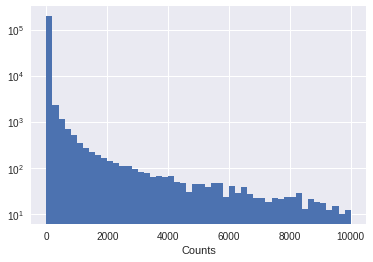

In [9]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [el for el in token_counts.keys() if token_counts[el] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [11]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [13]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [19]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 4167,  3518,    15,   142,  6078, 10885,    73, 12559,    73,
           110],
        [ 3199,   558,   559,   944,    86,  2454,    73,   561,  2541,
            86],
        [  110,  1293,  4128,   282,  1464,   944,    73,  2497,  6568,
             9]], dtype=int32),
 'Log1pSalary': array([10.307585, 10.085851, 10.532123], dtype=float32),
 'Title': array([[ 442, 1472, 1414,    1,    1,    1,    1,    1,    1,    1],
        [2541,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [ 177,  101,  102,   88, 1513, 7838, 7839, 9346, 1513,   34]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
use_cuda, torch.version.cuda, torch.__version__

(True, '9.2.148', '0.4.1')

In [0]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]
    
def maybe_batchnorm(model, use_batchnorm, name, bn):
    if use_batchnorm:
        model.add_module(name, bn)

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, emb_w=None, use_batchnorm=False, n_conv=1, n_tokens=len(tokens), emb_size=64, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        if emb_w is not None:
            self.emb.weight.data.copy_(torch.from_numpy(emb_w))
        
        self.encoder = nn.Sequential()
        for i in range(n_conv):
            self.encoder.add_module(f'conv{i}', nn.Conv1d(emb_size, out_size, kernel_size=3, padding=1))
            maybe_batchnorm(self.encoder, use_batchnorm, f'bn{i}', nn.BatchNorm1d(out_size))
            self.encoder.add_module(f'relu{i}', nn.ReLU())
        
        self.encoder.add_module('pool1', GlobalMaxPooling())
        self.encoder.add_module('dense', nn.Linear(out_size, out_size))

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        return self.encoder(h)

In [23]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, emb_w=None, use_batchnorm=False, n_conv=1, n_tokens=len(tokens), emb_size=64, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        if emb_w is not None:
            self.emb.weight.data.copy_(torch.from_numpy(emb_w))
        
        self.encoder = nn.Sequential()
        for i in range(n_conv):
            self.encoder.add_module(f'conv{i}', nn.Conv1d(emb_size, out_size, kernel_size=3, padding=1))
            maybe_batchnorm(self.encoder, use_batchnorm, f'bn{i}', nn.BatchNorm1d(out_size))
            self.encoder.add_module(f'relu{i}', nn.ReLU())
        
        self.encoder.add_module('pool1', GlobalMaxPooling())
        self.encoder.add_module('dense', nn.Linear(out_size, out_size))

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        return self.encoder(h)

In [25]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, emb_w=None, use_batchnorm=False, n_conv=1, emb_size=64, out_size=64, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(emb_w=emb_w, use_batchnorm=use_batchnorm, emb_size=emb_size, out_size=out_size)
        self.desc_encoder = DescriptionEncoder(emb_w=emb_w, use_batchnorm=use_batchnorm, emb_size=emb_size, out_size=out_size)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential()
        
        self.cat_encoder.add_module('dense1', nn.Linear(n_cat_features, 256))
        maybe_batchnorm(self.cat_encoder, use_batchnorm, 'bn1', nn.BatchNorm1d(256))
        self.cat_encoder.add_module('relu1', nn.ReLU())
        
        self.cat_encoder.add_module('dense2', nn.Linear(256, 128))
        maybe_batchnorm(self.cat_encoder, use_batchnorm, 'bn2', nn.BatchNorm1d(128))
        self.cat_encoder.add_module('relu2', nn.ReLU())
        
        self.cat_encoder.add_module('dense3', nn.Linear(128, out_size))
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.res_layer = nn.Sequential()
        
        self.res_layer.add_module('dense1', nn.Linear(out_size*3, 256))
        maybe_batchnorm(self.res_layer, use_batchnorm, 'bn1', nn.BatchNorm1d(256))
        self.res_layer.add_module('relu1', nn.ReLU())
        
        self.res_layer.add_module('dense2', nn.Linear(256, 64))
        maybe_batchnorm(self.res_layer, use_batchnorm, 'bn2', nn.BatchNorm1d(64))
        self.res_layer.add_module('relu2', nn.ReLU())
        
        self.res_layer.add_module('dense3', nn.Linear(64, 1))
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        result = self.res_layer(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return result[:, 0]

In [0]:
def maybe_cuda(tensor):
    return tensor.cuda() if use_cuda else tensor

In [0]:
model = maybe_cuda(FullNetwork())
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["FullDescription"])))
cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
reference = Variable(maybe_cuda(torch.FloatTensor(batch[target_column])))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
def after_each_epoch_fn(*args, **kwargs):
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    start = kwargs['epoch_start']
    end = kwargs['epoch_end']
    mae = kwargs['epoch_mae']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} epoch_mae: {mae:.4f}, epoch_time: {end - start:.2f} s', end='')

def after_each_batch_fn(*args, **kwargs):
    return
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} ({get_batch_string(*args, **kwargs)})', end='')

def get_batch_string(*args, **kwargs):
    batch_i = kwargs['batch_i']
    n_batch = kwargs['n_batch']
    start = kwargs['batch_start']
    end = kwargs['batch_end']
    loss = kwargs['batch_loss']
    return f'batch #{batch_i + 1}/{n_batch}, batch_loss: {loss:.5f}, batch_time: {end - start:.3f} s'

In [0]:
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    for start in range(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

По традиции прикрутил сохранение лучшей модели и early stopping, однако время обучения бейзлайна это не сократило и он учился 95 из 100 эпох с постепенным уменьшением MAE

In [0]:
import time

def train(name, model, opt, num_epochs=100, max_len=100, batch_size=32, batches_per_epoch=100, save_best=True, early_stop_after=10):
    val_mae_means = []    
    callback_params = {'n_epoch': num_epochs, 'n_batch': batches_per_epoch}
    for epoch_i in range(num_epochs):
        callback_params['epoch_i'] = epoch_i
        callback_params['epoch_start'] = time.time()

        train_loss = []
        model.train(True)

        for batch_i, batch in enumerate(iterate_minibatches(data_train, max_batches=batches_per_epoch)):
            callback_params['batch_i'] = batch_i
            callback_params['batch_start'] = time.time()

            title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
            desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["FullDescription"])))
            cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
            reference = Variable(maybe_cuda(torch.FloatTensor(batch[target_column])))

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss.append(loss[0].data.cpu().numpy())

            callback_params['batch_end'] = time.time()
            callback_params['batch_loss'] = train_loss[-1]

            after_each_batch_fn(**callback_params)

        val_mae = []
        model.train(False)

        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
            desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["FullDescription"])))
            cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
            reference = Variable(maybe_cuda(torch.FloatTensor(batch[target_column])))

            prediction = model(title_ix, desc_ix, cat_features)

            val_mae.append(compute_mae(reference, prediction).data.cpu().numpy())

        val_mae_means.append(np.mean(val_mae))

        local_max = np.min(val_mae_means)

        if save_best and val_mae_means[-1] == local_max:
            torch.save(model.state_dict(), name)

        callback_params['epoch_end'] = time.time()
        callback_params['epoch_mae'] = val_mae_means[-1]

        after_each_epoch_fn(**callback_params)

        if len(val_mae_means) > early_stop_after and local_max not in val_mae_means[-early_stop_after:]:
            print(f'\nEarly stopped after epoch #{epoch_i + 1}', end='')
            break
    print(f'\nBest validation MAE: {np.min(val_mae_means):.4f}' + (f', best model saved to "{name}"' if save_best else ''))

    plt.title(name)
    plt.xlabel('n_epoch')
    plt.ylabel('MAE')
    plt.plot(list(range(1, len(val_mae_means) + 1)), val_mae_means)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #99/100 epoch_mae: 2909.5713, epoch_time: 11.76 s
Early stopped after epoch #99
Best validation MAE: 2556.9465, best model saved to "baseline"


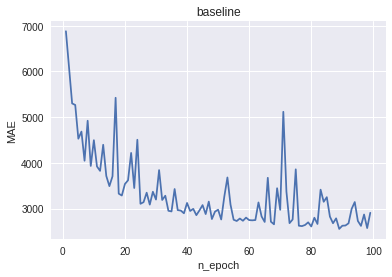

In [0]:
model = maybe_cuda(FullNetwork())
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('baseline', model, opt)

In [0]:
def evaluate(model):
    print("Final eval:")
    val_loss = val_mae = val_batches = 0

    for batch in iterate_minibatches(data_val):
        title_ix = Variable(maybe_cuda(torch.LongTensor(batch["Title"])))
        desc_ix = Variable(maybe_cuda(torch.LongTensor(batch["FullDescription"])))
        cat_features = Variable(maybe_cuda(torch.FloatTensor(batch["Categorical"])))
        reference = Variable(maybe_cuda(torch.FloatTensor(batch[target_column])))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()
        val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))

Посмотрим, какую модель мы бы получили без сохранения лучшего состояния

In [0]:
evaluate(model)

Final eval:
	Loss:	0.08557
	MAE:	2909.46599


Загрузим лучшее состояние

In [0]:
model.load_state_dict(torch.load('baseline'))
evaluate(model)

Final eval:
	Loss:	0.07311
	MAE:	2556.81319


### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #100/100 epoch_mae: 2514.4775, epoch_time: 12.52 s
Best validation MAE: 2514.4775, best model saved to "model_bn"


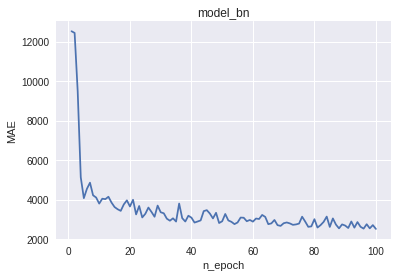

In [36]:
model = maybe_cuda(FullNetwork(use_batchnorm=True))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('model_bn', model, opt, early_stop_after=100)

In [37]:
model.load_state_dict(torch.load('model_bn'))
evaluate(model)

Final eval:
	Loss:	0.07053
	MAE:	2514.25064


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #100/100 epoch_mae: 3284.2405, epoch_time: 12.00 s
Best validation MAE: 2466.4321, best model saved to "model_more_neurons"


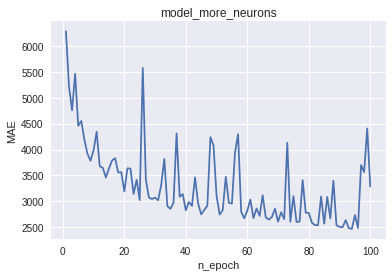

In [38]:
model = maybe_cuda(FullNetwork(out_size=128))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('model_more_neurons', model, opt, early_stop_after=100)

In [39]:
model.load_state_dict(torch.load('model_more_neurons'))
evaluate(model)

Final eval:
	Loss:	0.06834
	MAE:	2465.82688


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #100/100 epoch_mae: 2849.0901, epoch_time: 11.38 s
Best validation MAE: 2514.4583, best model saved to "model_more_layers"


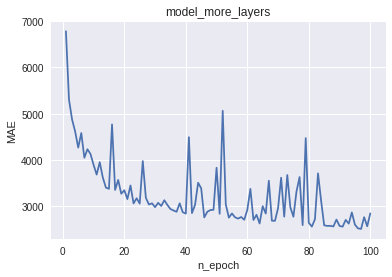

In [40]:
model = maybe_cuda(FullNetwork(n_conv=3))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('model_more_layers', model, opt, early_stop_after=100)

In [41]:
model.load_state_dict(torch.load('model_more_layers'))
evaluate(model)

Final eval:
	Loss:	0.07057
	MAE:	2513.87764


In [42]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 15.4MB/s 
    100% |████████████████████████████████| 133kB 25.7MB/s 
    100% |████████████████████████████████| 61kB 23.1MB/s 
    100% |████████████████████████████████| 4.9MB 6.5MB/s 
    100% |████████████████████████████████| 552kB 24.5MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [43]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [44]:
indices = {}
mat = np.zeros((len(tokens), embeddings.wv.vectors.shape[1]))
for e in embeddings.vocab:
    if e in token_to_id:
        mat[token_to_id[e], : ] = embeddings[e]

print(len(tokens))
print(mat.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


34158
(34158, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #100/100 epoch_mae: 2357.0181, epoch_time: 14.64 s
Best validation MAE: 2339.2788, best model saved to "model_pretrained_emb"


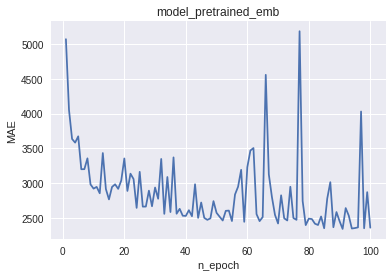

In [45]:
model = maybe_cuda(FullNetwork(emb_w=mat, emb_size=embeddings.wv.vectors.shape[1]))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('model_pretrained_emb', model, opt, early_stop_after=100)

In [46]:
model.load_state_dict(torch.load('model_pretrained_emb'))
evaluate(model)

Final eval:
	Loss:	0.06165
	MAE:	2337.51023


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #100/100 epoch_mae: 2311.3328, epoch_time: 15.85 s
Best validation MAE: 2294.1450, best model saved to "model_ultimate"


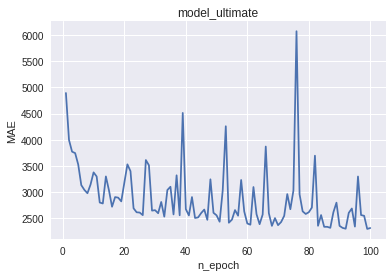

In [53]:
model = maybe_cuda(FullNetwork(out_size=128, emb_w=mat, emb_size=embeddings.wv.vectors.shape[1]))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train('model_ultimate', model, opt, early_stop_after=100)

In [54]:
model.load_state_dict(torch.load('model_ultimate'))
evaluate(model)

Final eval:
	Loss:	0.06017
	MAE:	2291.76254


In [58]:
import pandas as pd

data = {
    'baseline': 2909.46599,
    'baseline+save_best': 2556.81319,
    'model_bn': 2514.25064,
    'model_more_neurons': 2465.82688,
    'model_more_layers': 2513.87764,
    'model_pretrained_emb': 2337.51023,
    'model_ultimate': 2291.76254
}

titles, values = zip(*sorted(data.items(), key=lambda x: x[1]))

pd.DataFrame.from_dict({'title': titles, 'MAE': values})

,MAE,title
0,2291.76254,model_ultimate
1,2337.51023,model_pretrained_emb
2,2465.82688,model_more_neurons
3,2513.87764,model_more_layers
4,2514.25064,model_bn
5,2556.81319,baseline+save_best
6,2909.46599,baseline


### A short report

Please tell us what you did and how did it work.

* Использовал сохранение лучшей модели
* Думал об использовании early stopping'а, но бейзлайн модель с ним обучалась честные 99 эпох из 100, поэтому при обучении последующих моделей тоже обучал честные 100 эпох чтобы результаты можно было корректно сравнивать
* Добавил батч нормализацию, качество немного улучшилось по сравнению с бейзлайном (`model_bn` в таблице)
* Попробовал добаить больше сверточных слоев, качество также улучшилось по сравнению с бейзлайном (`model_more_layers` в таблице)
* Попробовал увеличить размер сверточных слоев (`out_size`) с 64 до 128, качество значительно улучшилось (`model_more_neurons`)
* Попробовал использовать предобученные embedding'и, качество значительно улучшилось (в таблице `model_pretrained_emb`).
* Скомбинировал предобученные эмбединги и увеличение размера сверточных слоев, которые до этого дали значительное улучшение качества, получил дальнейшее улучшение качества (`model_ultimate` в таблице)